### Setup

In [1]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

DATA UPLOAD
- user uploads data
   - calculate n,k
   - calculate sparsity of y
   - calculate missing values of x by column
   - calcualte missing values of x by row
   - calculate n if rows with missing vals dropped
   - calculate rank of resulting matrix (k_drop_r)
   
- Train/test split






In [3]:
test_share=0.2 
cv_folds=10
cv_reps=3
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility

##### Example Dataset

In [4]:
X, y, w = make_regression(n_samples=15,
                          n_features=10, # x variables generated and returned 
                          n_informative=4, # x variables included in the actual model of y
                          effective_rank=2, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=2,
                          random_state=rs,
                          bias=0.5)
y=y*np.sin(y)

In [5]:
# add interaction terms

In [6]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

### Model Selection

In [7]:
# for elastic_net, add custom transformer to change data to Fortran contiguous if not?
linear_regression=lambda: make_pipeline(StandardScaler(),LinearRegression()) # lambda so args,kwargs can be specified now rather than later
elastic_net =lambda: make_pipeline(StandardScaler(), ElasticNetCV())
#linear_svr = make_pipeline(StandardScaler(),GridSearchCV(LinearSVR(random_state=rs,tol=1e-3,max_iter=5000),n_jobs=1,param_grid={'C':np.linspace(-1,4,8)}))
linear_svr =lambda: make_pipeline(StandardScaler(),LinearSVR(random_state=rs,tol=1e-4,max_iter=5000,C=1))
rbf_svr=lambda: make_pipeline(StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(GradientBoostingRegressor())


estimator_dict={'linear-regression':linear_regression,
            'elastic-net':elastic_net, 
            'linear-svr':linear_svr, 
            'rbf-svr':rbf_svr, 
            'gradient-boosting-reg':gradient_boosting_reg}
model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [8]:
linear_svr = Pipeline(steps=[('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=10000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,2,5)}  
linear_svr_CV=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=10000, cache_size=2*10**3))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,5),
                   'rbf_svr__gamma':np.logspace(-1,0.5,5)} 
rbf_svr_CV=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)
                      
model_dict['rbf-svr-CV']=rbf_svr_CV()
model_dict['linear-svr-CV']=linear_svr_CV()

In [9]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [10]:
cv_results={estimator_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for estimator_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [11]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    #cv_estimator_names=[str(type(est)).split(".")[-1][:-2] for est in cv_estimators
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}
    cv_score_dict[estimator_name]=model_idx_scoredict # fstring bc how cross_validate stores list of metrics
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [12]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression:-1231702.4903597943
    elastic-net:-148.58118874026792
    linear-svr:-150.44065013416642
    rbf-svr:-116.91403518848402
    gradient-boosting-reg:-232.70639464589763
    rbf-svr-CV:-135.66846644230705
    linear-svr-CV:-129.65484113463262
scores for scorer: neg_mean_absolute_error:
    linear-regression:-326.8462270410858
    elastic-net:-9.892930364342739
    linear-svr:-8.994991034597893
    rbf-svr:-8.208641640250276
    gradient-boosting-reg:-10.744403660744483
    rbf-svr-CV:-9.733838263164943
    linear-svr-CV:-8.705507701822757
scores for scorer: r2:
    linear-regression:nan
    elastic-net:nan
    linear-svr:nan
    rbf-svr:nan
    gradient-boosting-reg:nan
    rbf-svr-CV:nan
    linear-svr-CV:nan


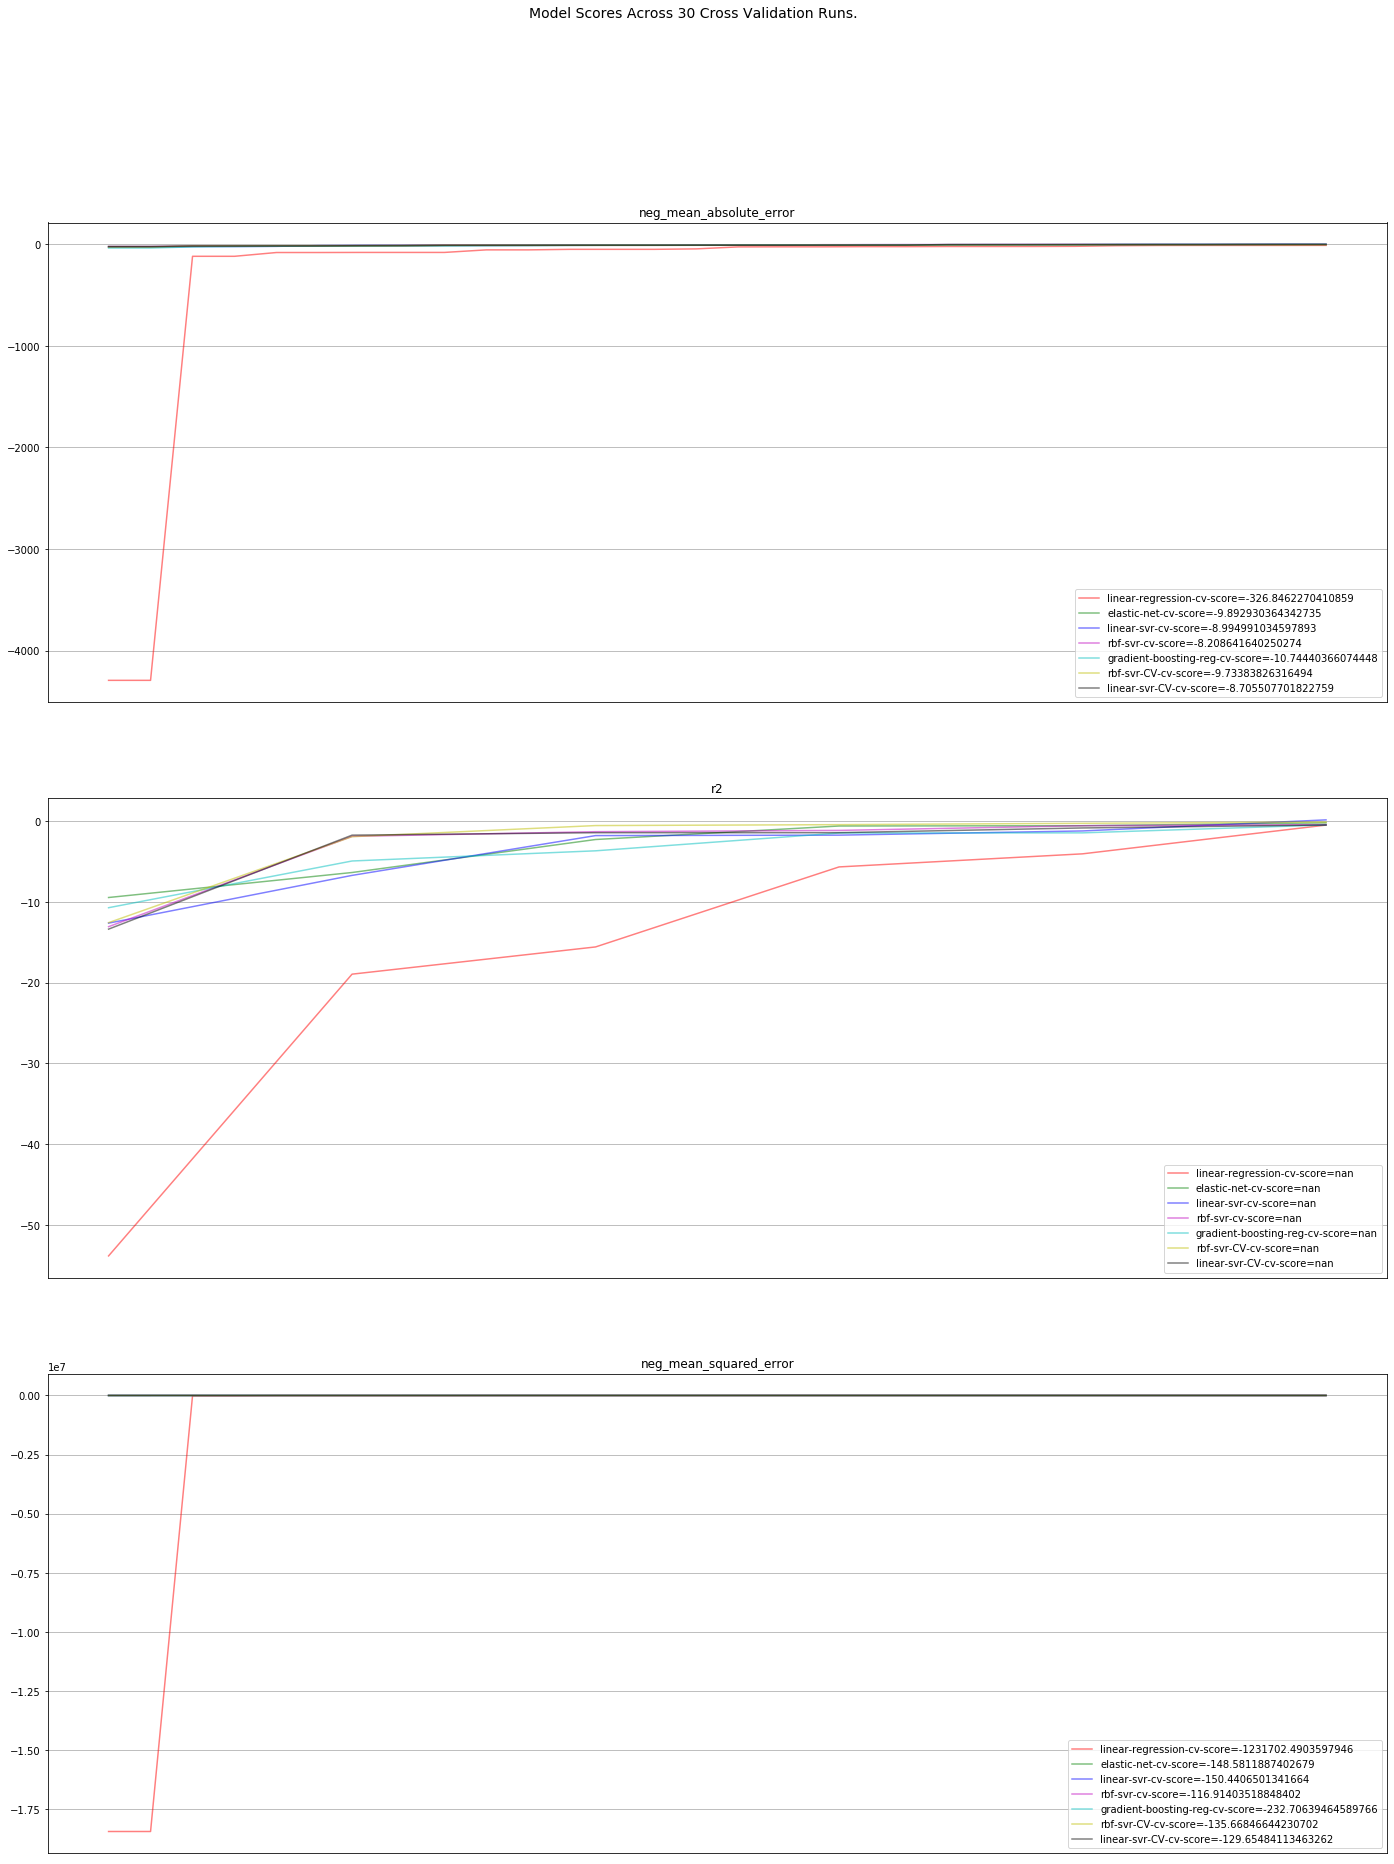

In [13]:
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']    
fig=plt.figure(figsize=[24,30])
plt.suptitle(f"Model Scores Across {cv_count} Cross Validation Runs. ", fontsize=14)
s_count=len(scorer_list)
xidx=np.arange(cv_count) # place holder for scatterplot

for s_idx, scorer in enumerate(scorer_list):
    ax=fig.add_subplot(f'{s_count}1{s_idx}')
    #ax.set_xlabel('estimator')
    #ax.set_ylabel(scorer)
    ax.set_title(scorer)
    sortidx=np.argsort(cv_score_dict['elastic-net'][scorer])
    #sortidx=np.argsort(cv_score_dict['linear-regression'][scorer])
    #sortidx=slice(None)
    for m_idx,estimator_name in enumerate(cv_results.keys()):
        scores=cv_score_dict[estimator_name][scorer]
        scores.sort()
        ax.plot(xidx,scores,color=colors[m_idx],alpha=0.5,label=estimator_name+'-cv-score='+str(np.mean(cv_score_dict[estimator_name][scorer])))
    ax.grid(True)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_visible(False)
    ax.legend(loc=4)

    

In [14]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses elastic net!


In [15]:
final_estimator_name='elastic-net'

In [16]:
def printTestandCVScores(estimator_name):
    final_model=estimator_dict[estimator_name]()
    final_model.fit(X_train,y_train)
    if test_share:
        y_test_hat=final_model.predict(X_test)
        print(f'test set: negative-mse={-mean_squared_error(y_test,y_test_hat)}')
    for scorer in scorer_list:
        print(f'cv avg: {scorer}= {cv_score_dict_means[estimator_name][scorer]}')    

In [17]:
printTestandCVScores(final_estimator_name)

test set: negative-mse=-70.32679515344435
cv avg: neg_mean_squared_error= -148.58118874026792
cv avg: neg_mean_absolute_error= -9.892930364342739
cv avg: r2= nan


In [18]:
printTestandCVScores('linear-regression')

test set: negative-mse=-994.5415518332762
cv avg: neg_mean_squared_error= -1231702.4903597943
cv avg: neg_mean_absolute_error= -326.8462270410858
cv avg: r2= nan


## Next Steps
- ### add options for dealing with important but underrepresented values of Y
- ### construct model averaging using average cross validation scores
- ### predict with confidence intervals 
  -    #### could use variability from cv
  -   #### some algorithms have their own method
